In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt
import math

%matplotlib inline
plt.style.use("ggplot")

In [2]:
import yfinance as yf

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return(data - data.shift(1))/data.shift(1)

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Read Portfolios and trading Strategies

In [3]:
%run -i 'portfolio.py'

In [4]:
data = pd.read_csv("./data/portfolio_dataset.csv", low_memory=False)#, nrows= 10000)

data["datadate"] = pd.to_datetime(data["datadate"])
print("Number of unique tickers:",len(data.tic.value_counts()))
data = data[["datadate","tic","div","cshoc","prccd"]].sort_values(by= "datadate")\
                                                .rename({'cshoc':'shares',
                                                #     'prchd':'high',
                                                #     'prcld':'low',
                                                #     'prcod':'open',
                                                        'prccd':'close',}, axis = 1).\
                                                reset_index(drop=True)
data = data[data["datadate"] >= pd.to_datetime("01-01-2010")]



data["div"] = data["div"].fillna(0)
print("Dimensions: ",data.shape)
data

Number of unique tickers: 36
Dimensions:  (65535, 5)


,datadate,tic,div,shares,close
0,2010-01-04,AAMRQ,0.0,332456000.0,7.72
1,2010-01-04,AMD,0.0,670361000.0,9.70
2,2010-01-04,NBR,0.0,283290000.0,23.19
3,2010-01-04,AET,0.0,433500000.0,33.00
4,2010-01-04,APD,0.0,211706000.0,83.16
...,...,...,...,...,...
65530,2021-10-08,AME,0.0,231206000.0,126.19
65531,2021-10-08,AEP,0.0,500251000.0,83.58
65532,2021-10-08,AIG.PA,0.0,20000000.0,27.13
65533,2021-10-08,ADI,0.0,537411000.0,168.62


***

# S&P 500 Replicating Portfolio

## Read S&P 500 Index Constituent Data

- WRDS Method _(includes historical data)_

In [5]:
spy_ticker_data = pd.read_csv("./data/sp500_constituents.csv")
spy_ticker_set = set(spy_ticker_data["Symbol"])
print("Unique Indices:",len(spy_ticker_set))
spy_ticker = dict()
for year in spy_ticker_data["Year"].unique():
    spy_ticker[year] = list(spy_ticker_data[spy_ticker_data["Year"] == year]["Symbol"])
# spy_ticker

FileNotFoundError: [Errno 2] No such file or directory: './data/sp500_constituents.csv'

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [6]:
spy_dataframe = data[data["datadate"] >= pd.to_datetime("01-01-2010")]

# Temporay measure b/c our spy_ticker does not have 2021 data
spy_dataframe = data[data["datadate"] <= pd.to_datetime("01-01-2021")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

Number of unique tickers: 1190
Dimensions:  (2183146, 5)
datadate        0
tic             0
div             0
shares      49497
close         553
dtype: int64


,datadate,tic,div,shares,close
5592,2010-01-13,Z.1,0.1546,NaN,NaN
8973,2010-01-20,RRD.2,0.2721,NaN,NaN
12443,2010-01-27,5050B,0.1950,NaN,NaN
20504,2010-02-10,0051B,0.1250,NaN,NaN
20505,2010-02-10,0050B,0.0730,NaN,NaN
...,...,...,...,...,...
2141545,2020-10-15,Z.1,0.1983,NaN,NaN
2142940,2020-10-16,PLP.Z,0.5671,NaN,NaN
2165919,2020-11-30,6525B,0.4005,NaN,NaN
2173465,2020-12-14,AHC.2,0.3187,NaN,NaN


**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [7]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

datadate        0
tic             0
div             0
shares      48944
close           0
dtype: int64


In [8]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

div        shares   close
datadate   tic                              
2010-01-04 AAMRQ   0.0  3.324560e+08    7.72
           MRO     0.0  7.078450e+08   32.11
           PCS     0.0  3.524010e+08    7.97
           LOW     0.0  1.472032e+09   23.16
           GOOGL   0.0  2.429990e+08  626.75
...                ...           ...     ...
2020-12-31 EXR     0.0  1.292350e+08  115.86
           AON     0.0  2.286160e+08  211.27
           BAC.PM  0.0  5.590000e+07   27.31
           MSI     0.0  1.695230e+08  170.06
           L       0.0  2.748730e+08   45.02

[2182593 rows x 3 columns]

In [9]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [10]:
spy_portfolio = Portfolio(target="S&P500",
                        tickerset= spy_ticker, investment= 1000000,
                        trading_algo= "SNP500_Algo",
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: S&P500
Trading Algorithm: MarketCap Weighted Portfolio
Starting Investment: 1000000
Current Investment: 1000000


In [11]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = spy_data.loc[date,:]
    valuation, returns =  spy_portfolio.run(date= date, price= tmpdf, tickerlist = spy_ticker[date.year])
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010


/Users/rchaks/Code/GitHub/portfolio-management/trading_algo.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price["cap"] = price["shares"]*price["close"]


	Rebalancing on: 03-May-2010
	Rebalancing on: 01-Sep-2010
Reconstitution on: 03-Jan-2011
	Rebalancing on: 03-Jan-2011
	Rebalancing on: 02-May-2011
	Rebalancing on: 01-Sep-2011
Reconstitution on: 03-Jan-2012
	Rebalancing on: 03-Jan-2012
	Rebalancing on: 01-May-2012
	Rebalancing on: 04-Sep-2012
2012-10-26 00:00:00 2012-10-29 -1 -1
Reconstitution on: 02-Jan-2013
	Rebalancing on: 02-Jan-2013
	Rebalancing on: 01-May-2013
	Rebalancing on: 03-Sep-2013
Reconstitution on: 02-Jan-2014
	Rebalancing on: 02-Jan-2014
	Rebalancing on: 01-May-2014
2014-05-23 00:00:00 2014-05-26 -1 -1
2014-07-03 00:00:00 2014-07-04 -1 -1
	Rebalancing on: 02-Sep-2014
2014-11-26 00:00:00 2014-11-27 -1 -1
Reconstitution on: 02-Jan-2015
	Rebalancing on: 02-Jan-2015
2015-01-16 00:00:00 2015-01-19 -1 -1
	Rebalancing on: 01-May-2015
2015-05-22 00:00:00 2015-05-25 -1 -1
2015-07-02 00:00:00 2015-07-03 -1 -1
	Rebalancing on: 01-Sep-2015
2015-11-25 00:00:00 2015-11-26 -1 -1
Reconstitution on: 04-Jan-2016
	Rebalancing on: 04-Jan-2

In [12]:
spy_portfolio.echo()
# print("Net return since start: ",spy_portfolio.net_return()*100,"%")

Target Index: S&P500
Trading Algorithm: MarketCap Weighted Portfolio
Starting Investment: 1000000
Current Investment: 3004668.62857526
Constituent Indices: MMM, ABT, ABBV, ABMD, ACN ...
Constituent Weights: tic
SWK     14.555927
DXC     23.171327
O       31.452277
EFX     11.071500
NTRS    18.968866
dtype: float64


In [13]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns.fillna(1)+1)-1)*100,"%")

daily return:  0.04143867599750717 %


## S&P Index, ETF and Mutual Fund

In [14]:
benchmark_data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2020-12-31")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,113.330002,NaN,1132.989990
2010-01-05,113.629997,NaN,1136.520020
2010-01-06,113.709999,NaN,1137.140015
2010-01-07,114.190002,NaN,1141.689941
2010-01-08,114.570000,NaN,1144.979980


In [15]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,SPY,VFIAX,^GSPC
Date,,,
2010-01-04,0.000000,0.0,0.000000
2010-01-05,0.002647,0.0,0.003116
2010-01-06,0.000704,0.0,0.000546
2010-01-07,0.004221,0.0,0.004001
2010-01-08,0.003328,0.0,0.002882


## Plot

In [16]:
# fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
# fig.set_size_inches(30, 10,  forward=True)

# ax[0].plot(portfolio_val)
# ax[0].plot(benchmark_data["^GSPC"]*900)
# ax[0].plot(benchmark_data["SPY"]*8961.3)
# ax[0].plot(benchmark_data["VFIAX"]*9600)
# ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
# ax[0].set_title("Portfolio v/s benchmarks - Valuation")

# ax[1].plot(portfolio_returns)
# ax[1].plot(baseline_return["^GSPC"])
# ax[1].plot(baseline_return["SPY"])
# ax[1].plot(baseline_return["VFIAX"])
# ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Portfolio Daily Returns")
# ax[1].set_title("Portfolio v/s benchmarks - Returns")

# fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

In [17]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and SPY is 0.27%
Tracking error between our portfolio and VFIAX is 0.8999999999999999%
Tracking error between our portfolio and ^GSPC is 0.255%


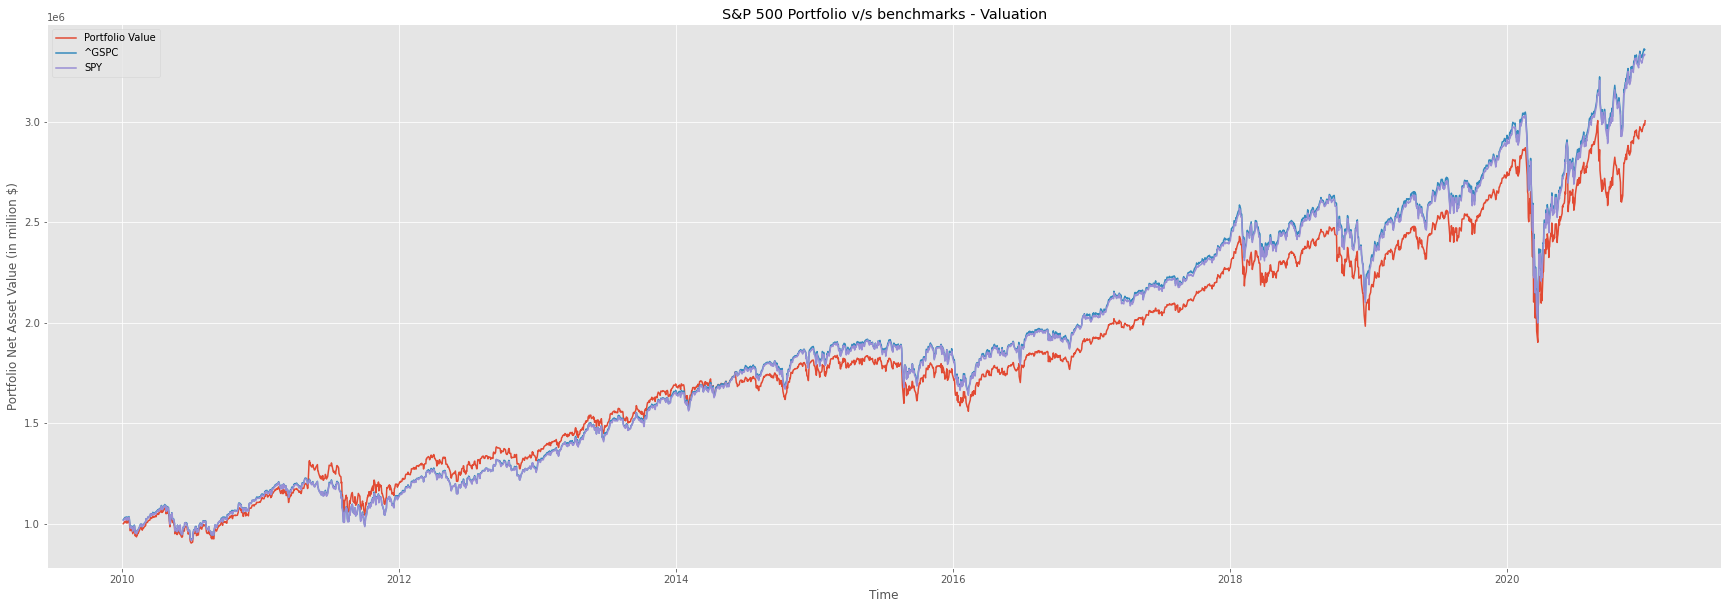

In [18]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot(benchmark_data["^GSPC"]*900)
plt.plot(benchmark_data["SPY"]*8961.3)
# plt.plot(benchmark_data["VFIAX"]*9600)
plt.legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("S&P 500 Portfolio v/s benchmarks - Valuation")
plt.show()

***

# DJIA Replicating Portfolio

## Read DJIA Index Constituent Data

- WRDS Method _(includes historical data)_

In [19]:
djia_ticker_data = pd.read_csv("./data/dj_constituents.csv")
djia_ticker_set = set(djia_ticker_data["Symbol"])
print("Unique Indices:",len(djia_ticker_data))
djia_ticker = dict()
for year in djia_ticker_data["Year"].unique():
    djia_ticker[year] = list(djia_ticker_data[djia_ticker_data["Year"] == year]["Symbol"])
djia_ticker

Unique Indices: 330


{2010: ['MMM',
  'DD',
  'MCD',
  'AA',
  'XOM',
  'MRK',
  'AXP',
  'GE',
  'MSFT',
  'T',
  'HP',
  'PFE',
  'BAC',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'KFT',
  'DIS'],
 2011: ['MMM',
  'DD',
  'MCD',
  'AA',
  'XOM',
  'MRK',
  'AXP',
  'GE',
  'MSFT',
  'T',
  'HP',
  'PFE',
  'BAC',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'KFT',
  'DIS'],
 2012: ['MMM',
  'DD',
  'MRK',
  'AA',
  'XOM',
  'MSFT',
  'AXP',
  'GE',
  'PFE',
  'T',
  'HPQ',
  'PG',
  'BAC',
  'HD',
  'TRV',
  'BA',
  'INTC',
  'UNH',
  'CAT',
  'IBM',
  'UTX',
  'CVX',
  'JNJ',
  'VZ',
  'CSCO',
  'JPM',
  'WMT',
  'KO',
  'MCD',
  'DIS'],
 2013: ['MMM',
  'GE',
  'NKE',
  'AXP',
  'GS',
  'PFE',
  'T',
  'HD',
  'PG',
  'BA',
  'INTC',
  'TRV',
  'CAT',
  'IBM',
  'UNH',
  'CVX',
  'JNJ',
  'UTX',
  'CSCO',
  'JPM',
  'VZ',
  '

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [20]:
djia_dataframe = data[data["tic"].apply(lambda x: (x in djia_ticker_set))].copy()
djia_dataframe = djia_dataframe[djia_dataframe["datadate"] >= pd.to_datetime("01-01-2010")]
print("Number of unique tickers:",len(djia_dataframe.tic.value_counts()))
djia_data = djia_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",djia_data.shape)
print(djia_data.isna().sum())
djia_data[np.isnan(djia_data.close)]

Number of unique tickers: 39
Dimensions:  (111530, 5)
datadate    0
tic         0
div         0
shares      9
close       0
dtype: int64


,datadate,tic,div,shares,close


In [21]:
djia_data = djia_data.set_index(["datadate","tic"])
djia_data

div        shares   close
datadate   tic                            
2010-01-04 MMM   0.0  7.079580e+08   83.02
           MRK   0.0  3.054476e+09   37.01
           MCD   0.0  1.079187e+09   62.78
           CRM   0.0  1.249000e+08   74.82
           HD    0.0  1.700412e+09   28.67
...              ...           ...     ...
2021-10-08 HON   0.0  6.903990e+08  217.70
           GS    0.0  3.397620e+08  392.81
           WBA   0.0  8.649870e+08   47.38
           WMT   0.0  2.788498e+09  139.66
           MSFT  0.0  7.514891e+09  294.85

[111530 rows x 3 columns]

In [22]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],djia_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-01-04 00:00:00'),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2010-01-06 00:00:00'),
 Timestamp('2010-01-07 00:00:00'),
 Timestamp('2010-01-08 00:00:00')]

## Executing Portfolio

In [23]:
djia_portfolio = Portfolio(target="Dow Jones Algo",
                        tickerset= djia_ticker, investment= 1000000,
                        trading_algo= "DJIA_Algo",
                        rebalance=4, reconstitute=12)

djia_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Dow Jones Algo
Trading Algorithm: Price Cap Weighted
Starting Investment: 1000000
Current Investment: 1000000


In [24]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = djia_data.loc[date,:]
    
    valuation, returns =  djia_portfolio.run(date= date, price= tmpdf, tickerlist = djia_ticker[date.year])
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
    # print(date.strftime("%d-%m-%Y"), valuation, returns)

Reconstitution on: 04-Jan-2010
	Rebalancing on: 04-Jan-2010
	Rebalancing on: 03-May-2010
	Rebalancing on: 01-Sep-2010
Reconstitution on: 03-Jan-2011
	Rebalancing on: 03-Jan-2011
	Rebalancing on: 02-May-2011
	Rebalancing on: 01-Sep-2011
Reconstitution on: 03-Jan-2012
	Rebalancing on: 03-Jan-2012
	Rebalancing on: 01-May-2012
	Rebalancing on: 04-Sep-2012
Reconstitution on: 02-Jan-2013
	Rebalancing on: 02-Jan-2013
	Rebalancing on: 01-May-2013
	Rebalancing on: 03-Sep-2013
Reconstitution on: 02-Jan-2014
	Rebalancing on: 02-Jan-2014
	Rebalancing on: 01-May-2014
	Rebalancing on: 02-Sep-2014
Reconstitution on: 02-Jan-2015
	Rebalancing on: 02-Jan-2015
	Rebalancing on: 01-May-2015
	Rebalancing on: 01-Sep-2015
Reconstitution on: 04-Jan-2016
	Rebalancing on: 04-Jan-2016
	Rebalancing on: 02-May-2016
	Rebalancing on: 01-Sep-2016
Reconstitution on: 03-Jan-2017
	Rebalancing on: 03-Jan-2017
	Rebalancing on: 01-May-2017
	Rebalancing on: 01-Sep-2017
Reconstitution on: 02-Jan-2018
	Rebalancing on: 02-Jan-2

KeyError: 2021

In [25]:
djia_portfolio.echo()
# print("Net return since start: ",djia_portfolio.net_return()*100,"%")

Target Index: Dow Jones Algo
Trading Algorithm: Price Cap Weighted
Starting Investment: 1000000
Current Investment: 2614772.9648897876
Constituent Indices: MMM, GS, NKE, AXP, HD ...
Constituent Weights: tic
KO      562.094523
MCD     562.094523
WBA     562.094523
AXP     562.094523
INTC    562.094523
dtype: float64


In [26]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

daily return:  0.03365256360425839 %


## DJIA Index, ETF and Mutual Fund(Not yet available)

In [27]:
benchmark_data = yf.download("^DJI DIA VTSMX", start="2010-01-01", end="2021-10-07")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

[*********************100%***********************]  3 of 3 completed


,DIA,VTSMX,^DJI
Date,,,
2010-01-04,105.660004,NaN,10583.959961
2010-01-05,105.489998,NaN,10572.019531
2010-01-06,105.559998,NaN,10573.679688
2010-01-07,105.940002,NaN,10606.860352
2010-01-08,106.110001,NaN,10618.190430


In [28]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

,DIA,VTSMX,^DJI
Date,,,
2010-01-04,0.000000,0.0,0.000000
2010-01-05,-0.001609,0.0,-0.001128
2010-01-06,0.000664,0.0,0.000157
2010-01-07,0.003600,0.0,0.003138
2010-01-08,0.001605,0.0,0.001068


## Plot

In [29]:
# fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
# fig.set_size_inches(30, 10,  forward=True)

# ax[0].plot(portfolio_val)
# ax[0].plot((benchmark_data["^DJI"]-584)*100)
# ax[0].plot((benchmark_data["DIA"]-5.66)*10000)
# ax[0].plot(benchmark_data["VTSMX"]*30000 + 162700)
# ax[0].legend(["Portfolio Value","^DJI","DIA","VTSMX"])
# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
# ax[0].set_title("Portfolio v/s benchmarks - Valuation")

# ax[1].plot(portfolio_returns)
# ax[1].plot(baseline_return["^DJI"])
# ax[1].plot(baseline_return["DIA"])
# ax[1].plot(baseline_return["VTSMX"])
# ax[1].legend(["Portfolio Returns","^DJI","DIA","VTSMX"])
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Portfolio Daily Returns")
# ax[1].set_title("Portfolio v/s benchmarks - Returns")

# fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

In [30]:
tracking_error_djia = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_djia.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and DIA is 0.25%
Tracking error between our portfolio and VTSMX is 0.9129999999999999%
Tracking error between our portfolio and ^DJI is 0.23900000000000002%


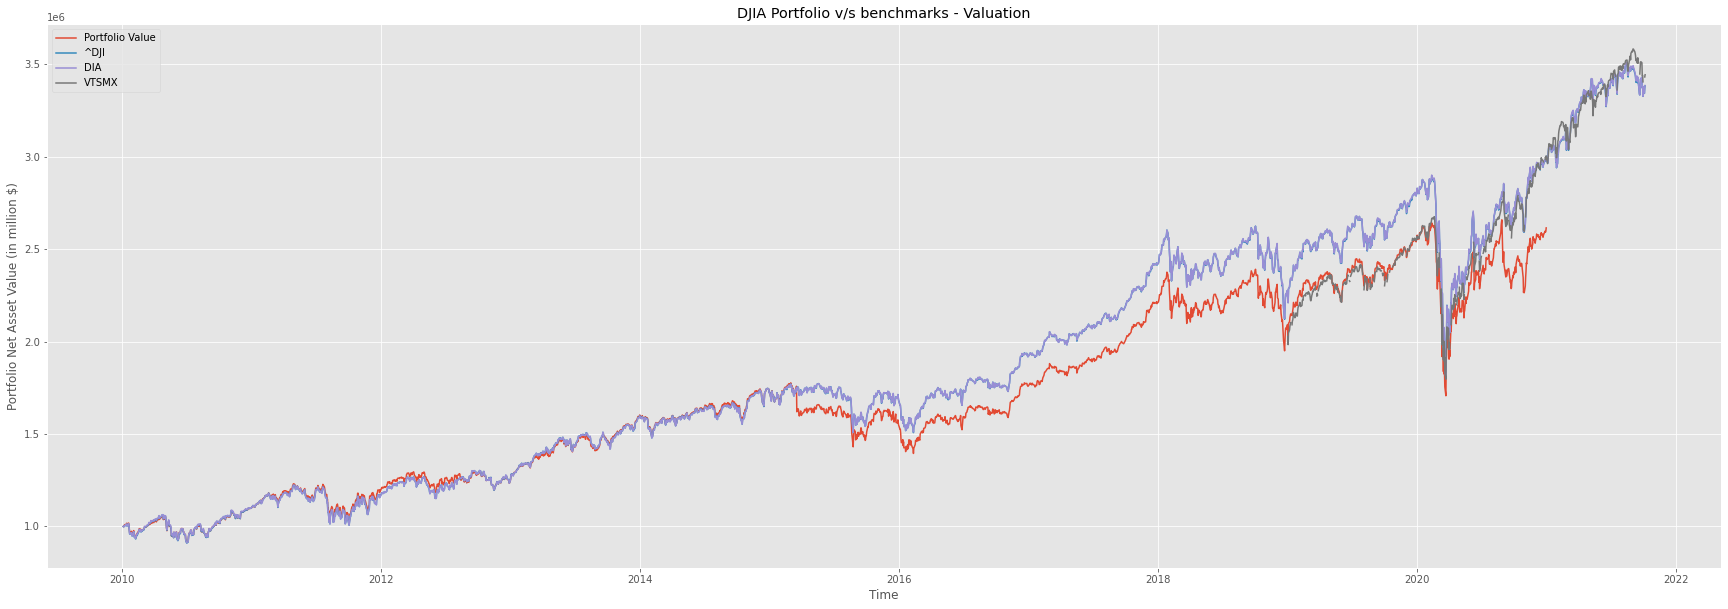

In [31]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot((benchmark_data["^DJI"]-584)*100)
plt.plot((benchmark_data["DIA"]-5.66)*10000)
plt.plot(benchmark_data["VTSMX"]*30000 + 162700)
plt.legend(["Portfolio Value","^DJI","DIA","VTSMX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("DJIA Portfolio v/s benchmarks - Valuation")
plt.show()

***
***